In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from invert import invert_ebb, invert_msp, load_source_time_series
from simulate import run_dipole_simulation
from laminar import sliding_window_model_comparison, model_comparison
from matplotlib import colors


In [5]:
sim_vertex=420
sim_patch_size=5
dipole_moment=10
SNR=-5
n_layers=11
layers = np.linspace(1, 0, n_layers)
signal_width=.025 # 25ms

data_dir='./test_data'
out_dir='./test_output'
tmp_dir='/scratch/bonaiuto/simulated_data/'
subj_id='sub-104'
ses_id='ses-01'
# Subject fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# T1
mri_fname = os.path.join(data_dir,'spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')

mesh_fname = os.path.join(out_dir, subj_id, 'multilayer.11.ds.link_vector.gii')

## Create intermediate surfaces if needed
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'pial.ds.link_vector.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join(out_dir, subj_id, f'{layer_name}.ds.link_vector.gii'))        
    elif layer == 0:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'white.ds.link_vector.gii'))

# Data file to base simulations on
data_file=os.path.join(data_dir, 'processed', subj_id, ses_id, 'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')

patch_size=5
n_temp_modes = 4
win_size=10
win_overlap=True

mesh=nib.load(mesh_fname)
verts_per_surf=int(mesh.darrays[0].data.shape[0]/n_layers)
subject_out_dir = os.path.join(out_dir, subj_id, 'inv')

In [25]:
# Invert the subject's data. This step only has to be done once
[base_fname,F,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, data_file, n_layers, 
                            patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [6]:
base_fname='/scratch/bonaiuto/simulated_data/multilayer.11.ds.link_vector.pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'

Text(0, 0.5, 'Amplitude (normalised)')

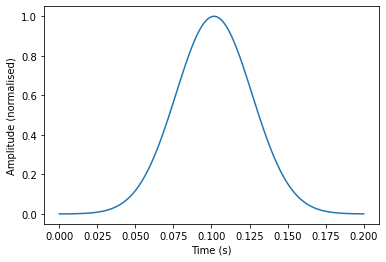

In [7]:
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]

signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2))

plt.figure()
plt.plot(time,signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalised)')

In [8]:
pial_vertex=sim_vertex
white_vertex=(n_layers-1)*int(verts_per_surf)+sim_vertex

pial_unit_norm=mesh.darrays[2].data[pial_vertex,:]
white_unit_norm=-1*mesh.darrays[2].data[white_vertex,:]

In [21]:
prefix=f'sim_{sim_vertex}_superficial.'
pial_sim_fname=run_dipole_simulation(base_fname, prefix, pial_vertex, signal, pial_unit_norm, dipole_moment, 
                                     sim_patch_size, SNR)    

In [22]:
[Fs,wois]=sliding_window_model_comparison(tmp_dir, sim_vertex, nas, lpa, rpa, mri_fname, 
                                          [layer_fnames[0], layer_fnames[-1]], pial_sim_fname, 
                                          patch_size=sim_patch_size, n_temp_modes=n_temp_modes,
                                          win_size=win_size, win_overlap=win_overlap)
Fs=np.array(Fs)
wois=np.array(wois)

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


Text(0, 0.5, '$\\Delta$F')

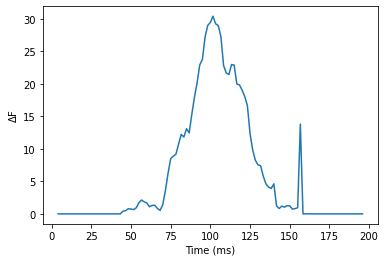

In [27]:
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

In [28]:
prefix=f'sim_{sim_vertex}_deep.'
white_sim_fname=run_dipole_simulation(base_fname, prefix, white_vertex, signal, white_unit_norm, dipole_moment, 
                                      sim_patch_size, SNR)    

In [29]:
[Fs,wois]=sliding_window_model_comparison(tmp_dir, sim_vertex, nas, lpa, rpa, mri_fname, 
                                          [layer_fnames[0], layer_fnames[-1]], white_sim_fname, 
                                          patch_size=sim_patch_size, n_temp_modes=n_temp_modes,
                                          win_size=win_size, win_overlap=win_overlap)
Fs=np.array(Fs)
wois=np.array(wois)

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


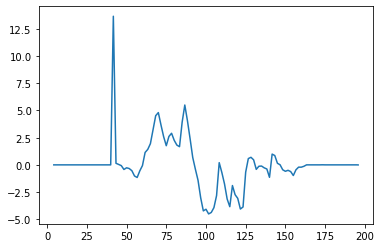

In [30]:
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

In [31]:
deep_width=.025
superficial_width=.01
deep_signal=np.exp(-((time-zero_time)**2)/(2*deep_width**2))
superficial_signal=np.exp(-((time-zero_time)**2)/(2*superficial_width**2))

sim_pos=[white_vertex, pial_vertex]
# Orientation of each dipole
sim_ori=np.vstack([white_unit_norm, pial_unit_norm])
# Dipole momemnts
sim_dipmom=[6, 8] # nAm
# Combined signal
sim_signal=np.vstack([deep_signal, superficial_signal])
# Width of patch
sim_dipfwhm=[5, 5] # mm
    

prefix=f'sim_{sim_vertex}_burst.'
burst_sim_fname=run_dipole_simulation(base_fname, prefix, sim_pos, sim_signal, sim_ori, sim_dipmom, sim_dipfwhm, SNR)    

Text(0, 0.5, 'Amplitude (normalised)')

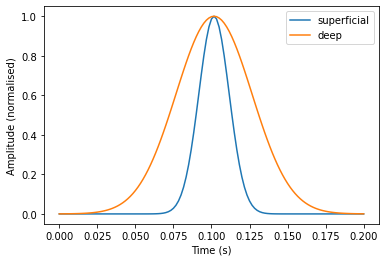

In [32]:
plt.figure()
plt.plot(time,superficial_signal, label='superficial')
plt.plot(time,deep_signal, label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalised)')

In [33]:
[Fs,wois]=sliding_window_model_comparison(tmp_dir, sim_vertex, nas, lpa, rpa, mri_fname, 
                                          [layer_fnames[0], layer_fnames[-1]], burst_sim_fname, 
                                          patch_size=sim_patch_size, n_temp_modes=n_temp_modes,
                                          win_size=win_size, win_overlap=win_overlap)

Fs=np.array(Fs)
wois=np.array(wois)

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


Text(0, 0.5, '$\\Delta$F')

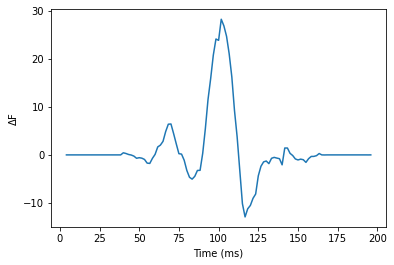

In [35]:
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

In [36]:
[Fs,wois]=sliding_window_model_comparison(tmp_dir, sim_vertex, nas, lpa, rpa, mri_fname, 
                                          layer_fnames, burst_sim_fname, 
                                          patch_size=sim_patch_size, n_temp_modes=n_temp_modes,
                                          win_size=win_size, win_overlap=win_overlap)

Fs=np.array(Fs)
wois=np.array(wois)

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/0.900.ds.link_vector.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ./test_output/sub-104/0.800.ds.link_vector.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ./test_output/sub-104/0.700.ds.link_vector.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ./test_output/sub-104/0.600.ds.link_vector.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ./test_output/sub-104/0.500.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ./test_output/sub-104/0.400.ds.link_vector.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ./test_output/sub-104/0.300.ds.link_vector.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ./test_output/sub-104/0.200.ds.link_vector.gii
FWHM of 5.00 is approx 3.48 times vertex spacing
Smoothing ./test_output/sub-104/0.100.ds.link_v

In [38]:
F_diff=np.zeros((Fs.shape[0],Fs.shape[1]))
for t in range(Fs.shape[1]):
    minF=np.min(Fs[:,t,0])
    F_diff[:,t]=Fs[:,t,0]-minF

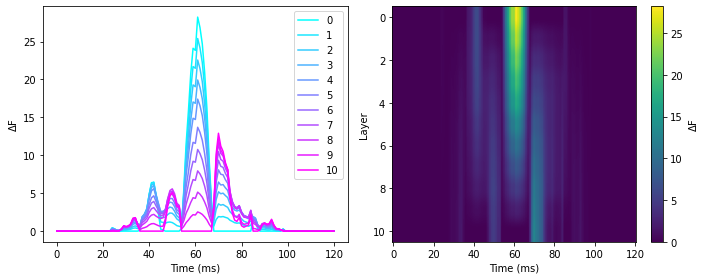

In [43]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(F_diff[l,:], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
plt.subplot(1,2,2)
h=plt.imshow(F_diff,aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
col_r=plt.colorbar(h)
col_r.set_label(r'$\Delta$F')
plt.tight_layout()